In [1]:
import datetime as dt 
import pandas as pd
from pandas_datareader import data as pdr 
import yfinance as yfin
import plotly.offline as pyo
import plotly.graph_objects as go 
from plotly.subplots import make_subplots 
import plotly.colors
import random
import numpy as np 
import pylab 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

Retrieving Stock Data

In [2]:
# SPECIFY START AND END DATES

end = dt.datetime.now()
start = dt.datetime(2018,1,1)
start, end

# SELECT STOCKS 

stocks = ['NVDA', 'META','CRWD','GOOGL','ADBE']

yfin.pdr_override()
df = pdr.get_data_yahoo(stocks,start,end)

df.head()
df.index # indexed by datetime days
df.columns # indexed by attribute and ticker

Close = df.Close # consider only closing price
Close.head()

[*********************100%%**********************]  5 of 5 completed


Ticker            ADBE  CRWD      GOOGL        META       NVDA
Date                                                          
2018-01-02  177.699997   NaN  53.660500  181.419998  49.837502
2018-01-03  181.039993   NaN  54.576000  184.669998  53.117500
2018-01-04  183.220001   NaN  54.787998  184.330002  53.397499
2018-01-05  185.339996   NaN  55.514500  186.850006  53.849998
2018-01-08  185.039993   NaN  55.710499  188.279999  55.500000

In [3]:
Close[Close.index > end - dt.timedelta(days=100)].describe(percentiles=[0.1,0.5,0.9]) # descriptive statistics for last 100 days (count = number of trading days)

Ticker        ADBE        CRWD       GOOGL        META        NVDA
count    69.000000   69.000000   69.000000   69.000000   69.000000
mean    532.869710  313.339129  148.907682  480.705072  820.565072
std      53.870495   12.887188    9.424766   30.513552   89.511509
min     462.829987  282.640015  131.399994  390.140015  615.270020
10%     473.157996  295.172003  137.484006  440.942004  691.102002
50%     519.140015  315.649994  148.740005  487.049988  857.739990
90%     616.243994  329.363995  160.084003  511.116010  909.973999
max     634.760010  334.549988  171.949997  527.340027  950.020020

In [4]:
Close.plot()

Plotting Stock Market Data

In [5]:
def plot_candles(ticker, start, end, moving_averages):
    
    # ticker is string
    # start, end are datetime
    # moving_averages are a list of integers

    ### GET STOCK DATA ###
    df = pdr.get_data_yahoo(ticker, start, end)

    ### COMPUTE MOVING AVERAGES ###
    for i in moving_averages: 
        idx = 'MA'+str(i)
        df[idx] = df['Close'].rolling(window=i,min_periods=0).mean()

    ### MAKE PLOT ###
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1, subplot_titles=(str(ticker),'Volume'),
                    row_width=[0.2,0.7])

    fig.add_trace(go.Candlestick(x=df.index, open=df['Open'],high=df['High'], low=df['Low'], close=df['Close'], name = 'OHLC'), row=1,col=1)
    fig.add_trace(go.Bar(x=df.index, y=df['Volume'], marker_color='red', showlegend=False), row=2,col=1)

    available_colors = plotly.colors.qualitative.Plotly
    random_colors = random.sample(available_colors, len(moving_averages))
    
    for i in range(len(moving_averages)): 
        idx = 'MA'+str(moving_averages[i])
        fig.add_trace(go.Scatter(x=df.index, y=df[idx], marker_color=random_colors[i], name=idx), row=1,col=1)

    fig.update_layout(
        title = str(ticker) + ' Historical Price Chart',
        xaxis_tickfont_size = 12,
        yaxis = dict(
            title='Price ($/share)',
            titlefont_size=14,
            tickfont_size=12
            ),
        autosize=False,
        width=800,
        height=800,
        margin=dict(l=50,r=50,b=100,t=100,pad=5),
        paper_bgcolor = 'LightSteelBlue'
    )

    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()
    


In [6]:
plot_candles('AC.TO',start=dt.datetime(2020,1,1), end = dt.datetime.now(), moving_averages=[50,100,200])
#pdr.get_data_yahoo('AC.TO', start, end)

[*********************100%%**********************]  1 of 1 completed


Simple vs Log Returns and Normality Assumptions

* Simple: product of normally distributed variables is not normally distributed
$R_t = \frac{P_t-P_{t-1}}{P_{t-1}}$
* Simple Multiperiod: $1 + R_t(k) = \prod_{i=1}^{k}(1+R_{t-i})$
* Log: the sum of normally distributed variables does follow a normal distribution

Goal: to create a function that assesses whether or not returns are normal for a given stock during a given time period
Note: Over time, financial data experiences large moves. Over a shorter time frame, returns are closer to being normally distributed.

In [7]:
def is_stock_normal(ticker, start, end, tolerance):

    # ticker is str
    # start, end are datetime
    # tolerance is float 
    
    df = pdr.get_data_yahoo(ticker, start, end)
    log_returns = np.log(df.Close/df.Close.shift(1)).dropna()

    # Plots 
    plt.figure(figsize=(12,6))

    plt.subplot(1,3,1)
    sns.histplot(log_returns, bins=10,color='skyblue',edgecolor='black',alpha=0.7)
    plt.title('Histogram of Log Returns')
    plt.xlabel('Log Returns')
    plt.ylabel('Frequency')

    plt.subplot(1,3,2)    
    stats.probplot(log_returns, dist='norm', plot=pylab)
    plt.title('Q-Q Plot')
    plt.xlabel('Theoretical')
    plt.ylabel('Observed')

    plt.subplot(1,3,3)
    sns.boxplot(y=log_returns, color='skyblue')
    plt.title('Box Plot of Log Returns')
    plt.xlabel(ticker)
    plt.ylabel('Log Returns')

    plt.show()
    
    # Probabilities 
    log_returns_sorted = log_returns.tolist()
    log_returns_sorted.sort()
    worst = log_returns_sorted[0]
    best = log_returns_sorted[-1]
    std_worst = (worst-log_returns.mean())/log_returns.std()
    std_best = (best-log_returns.mean())/log_returns.std()

    print("SD worst: %.2f SD best %.2f" %(std_worst, std_best))
    print("P(worst) %.2f P(best) %.2f" %(stats.norm(0,1).pdf(std_worst), stats.norm(0,1).pdf(std_best)))

    # Tests

    ## Kolmogorov Smirnov 
    ks_stat, p_value = stats.kstest(log_returns, 'norm')
    if p_value > tolerance:
        print('KS: Probably Gaussian')
    else: 
        print('KS: Probably not Gaussian')

    # Shapiro Wilke
    sw_stat, p_value = stats.shapiro(log_returns)
    if p_value > tolerance:
        print('SW: Probably Gaussian')
    else: 
        print('SW: Probably not Gaussian')


[*********************100%%**********************]  1 of 1 completed

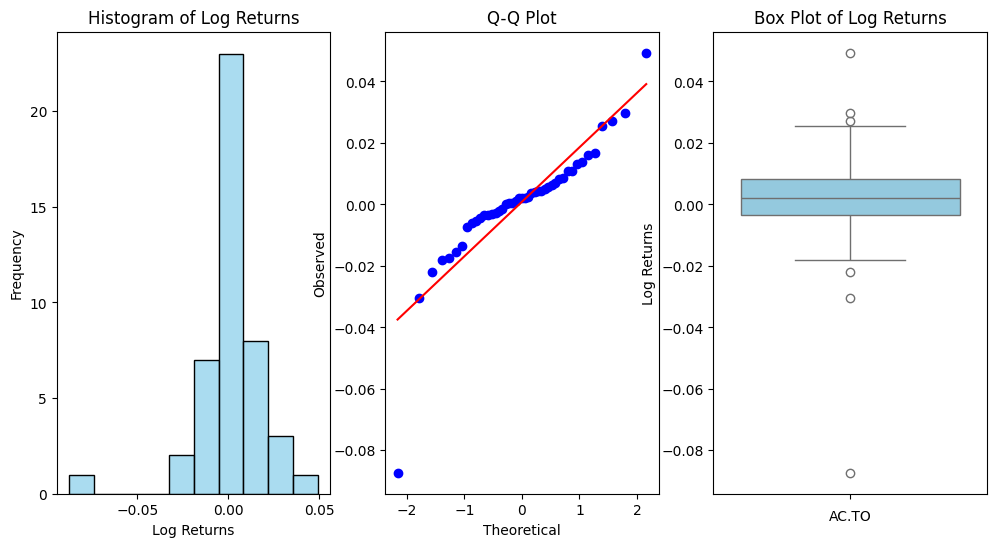

SD worst: -4.55 SD best 2.51
P(worst) 0.00 P(best) 0.02
KS: Probably not Gaussian
SW: Probably not Gaussian


In [8]:
is_stock_normal('AC.TO',end = dt.datetime.now(), start = dt.datetime(2024,3,1), tolerance=0.01)

In [38]:
### HISTORICAL VOLAITLITY AND RISK RETURN MEASURES ###

# SPECIFY START AND END DATES

end = dt.datetime.now()
start = dt.datetime(2018,1,1)
start, end

# SELECT STOCKS 

stocks = ['NVDA', 'META','CRWD','GOOGL','ADBE']
df = pdr.get_data_yahoo(stocks,start,end)
idx = pdr.get_data_yahoo('NDAQ',start,end)
Close = df.Close
idx_df = idx.Close
Close = pd.concat([idx_df,Close],axis=1)
Close.rename(columns={"Close":"NDAQ"})
Close.head()

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed


Close        ADBE  CRWD      GOOGL        META       NVDA
Date                                                                     
2018-01-02  25.580000  177.699997   NaN  53.660500  181.419998  49.837502
2018-01-03  25.886667  181.039993   NaN  54.576000  184.669998  53.117500
2018-01-04  26.230000  183.220001   NaN  54.787998  184.330002  53.397499
2018-01-05  26.403334  185.339996   NaN  55.514500  186.850006  53.849998
2018-01-08  26.653334  185.039993   NaN  55.710499  188.279999  55.500000

In [21]:
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()

# sd to get range of volatility
daily_std = log_returns.std()
annualized_vol = daily_std * np.sqrt(252) 

fig = make_subplots(rows=2,cols=2)

trace0 = go.Histogram(x=log_returns['ADBE'], name='ADBE')
trace1 = go.Histogram(x=log_returns['GOOGL'], name='GOOGL')
trace2 = go.Histogram(x=log_returns['META'], name='META')
trace3 = go.Histogram(x=log_returns['NVDA'], name='NVDA')

fig.append_trace(trace0,1,1)
fig.append_trace(trace1,1,2)
fig.append_trace(trace2,2,1)
fig.append_trace(trace3,2,2)

fig.update_layout(autosize=False,width=600,height=400,title="Freq of Log Returns",
                  )
fig.show()

In [22]:
# Trailing volaitlity over time 
TRADING_DAYS = 60
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS)
volatility.plot()

In [23]:
# Sharpe Ratio - average run divided by risk - return in excess of riskfree rate
Rf = 0.01/252 # daily
sharpe_ratio = (log_returns.rolling(window=TRADING_DAYS).mean() - Rf)*TRADING_DAYS
sharpe_ratio.plot()

In [28]:
# Sortino ratio - only considers downside volatility
sortino_vol = log_returns[log_returns<0].rolling(window=TRADING_DAYS, center=True, min_periods=10).std()*np.sqrt(TRADING_DAYS)
sortino_ratio = (log_returns.rolling(window=TRADING_DAYS).mean() - Rf)*TRADING_DAYS / sortino_vol

sortino_ratio.plot()

In [31]:
# M2 Ratio - adjusted risk of portfolio relative to that of some benchmark (in this case, ADBE)
m2_ratio = pd.DataFrame()
benchmark_vol = volatility['ADBE']
for c in log_returns.columns:
    if c != 'ADBE':
        m2_ratio[c] = (sharpe_ratio[c]*benchmark_vol/TRADING_DAYS + Rf)*TRADING_DAYS
m2_ratio.plot()

In [39]:
### BETA WEIGHTING YOUR PORTFOLIO ###

def calc_beta(df):
    np_array = df.values
    m = np_array[:,0]
    beta = []
    for ind, col in enumerate(df):
        if ind > 0:
            #stock returns indexed by ind 
            s = np_array[:,ind]
            # covar mat between stock and mkt 
            covariance = np.cov(s,m)
            beta.append( covariance[0,1]/covariance[1,1] )
    return pd.Series(beta, df.columns[1:], name='Beta')

In [40]:
calc_beta(log_returns)

Ticker
CRWD     0.751966
GOOGL    0.554090
META     0.681463
NVDA     0.897975
Name: Beta, dtype: float64

In [41]:
# OLS for coefficient of market and stock returns

def regression_beta(df):
    np_array = df.values
    m = np_array[:,0]
    beta = []
    for ind, col in enumerate(df):
        if ind > 0:
            #stock returns indexed by ind 
            s = np_array[:,ind]
            beta.append(stats.linregress(m,s)[0])        
    return pd.Series(beta, df.columns[1:], name='Beta')

In [42]:
regression_beta(log_returns)

Ticker
CRWD     0.751966
GOOGL    0.554090
META     0.681463
NVDA     0.897975
Name: Beta, dtype: float64